Installation

In [13]:
!git clone https://github.com/facebookresearch/ImageBind.git
!pip install git+https://github.com/facebookresearch/pytorchvideo.git@28fe037d212663c6a24f373b94cc5d478c8c1a1d timm==0.6.7 ftfy regex einops fvcore decord==0.6.0

Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 6.62 MiB/s, done.
Resolving deltas: 100% (68/68), done.
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-req-build-p_nfnu5n
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-req-build-p_nfnu5n
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 28fe037d2

Data Checker

In [2]:
%cd /content/ImageBind

/content/ImageBind


/content/ImageBind


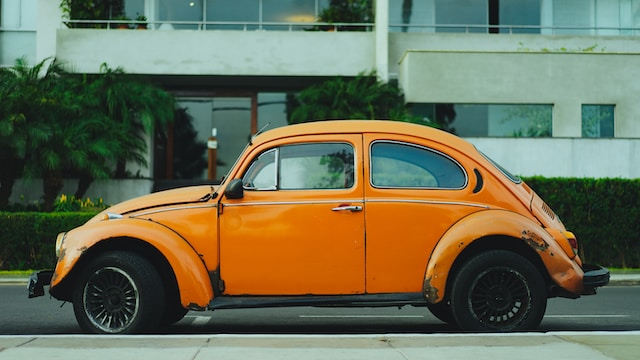

In [4]:
%cd /content/ImageBind
import IPython
from PIL import Image

text = 'car'
display(Image.open(f".assets/{text}_image.jpg"))
IPython.display.Audio(f".assets/{text}_audio.wav")

Inference

In [5]:
%cd /content/ImageBind

/content/ImageBind


Advanced Application plan

In [6]:
!pip install transformers

In [7]:
# depth estimator
# https://huggingface.co/spaces/nielsr/dpt-depth-estimation/blob/main/app.py
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image

In [8]:
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
text = "bird"
image = Image.open(f"/content/ImageBind/.assets/{text}_image.jpg")

In [10]:
encoding = feature_extractor(image, return_tensors="pt")

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=image.size[::-1],
                        mode="bicubic",
                        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy()
formatted = (output * 255 / np.max(output)).astype('uint8')
img = Image.fromarray(formatted)

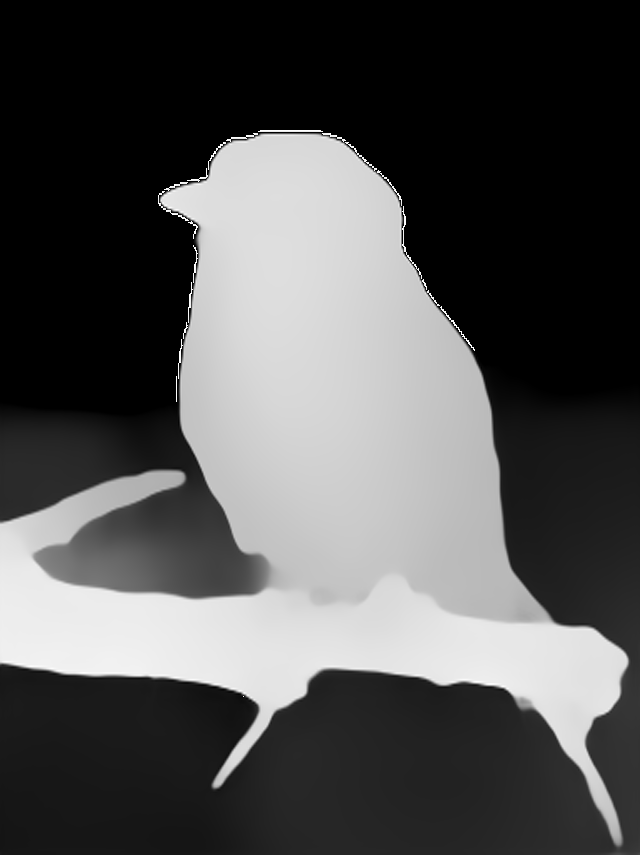

In [11]:
display(img)
img.save(f"/content/ImageBind/.assets/{text}_depth.jpg")

Cross modality

In [12]:
%cd /content/ImageBind

/content/ImageBind


In [13]:
from torchvision import transforms
from PIL import Image
def load_and_transform_depth_data(depth_paths, device):
    if depth_paths is None:
        return None

    depth_ouputs = []
    for depth_path in depth_paths:
        data_transform = transforms.Compose(
            [
                transforms.Resize(
                    224, interpolation=transforms.InterpolationMode.BICUBIC
                ),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                # transforms.Normalize((0.5, ), (0.5, ))
            ]
        )
        with open(depth_path, "rb") as fopen:
            image = Image.open(fopen).convert("L")

        image = data_transform(image).to(device)
        depth_ouputs.append(image)
    return torch.stack(depth_ouputs, dim=0)

In [3]:
%cd /content/ImageBind/


/content/ImageBind


In [8]:
!pip install torchvision==0.14
